In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('Combined_All.csv', encoding='cp1252')
print(data.columns.values)  

['Name' 'A_site' 'B_site' 'X_site' 'Spacegroup' 'Ehull' 'BulkModulus'
 'Energy' 'ZPE' 's_A' 's_B' 's_X' 'density' 'mean_A2B' 'mean_A2X'
 'mean_B2X' 'mean_X2X' 'std_A2B' 'std_A2X' 'std_B2X' 'std_X2X' 'E_coh'
 'TF' 'OF' 'A_Z' 'B_Z' 'X_Z' 'A_M' 'B_M' 'X_M' 'A_G' 'B_G' 'X_G' 'A_IEI'
 'B_IEI' 'X_IEI' 'A_IEII' 'B_IEII' 'X_IEII' 'A_EA' 'B_EA' 'X_EA' 'A_ChiP'
 'B_ChiP' 'X_ChiP' 'A_ChiA' 'B_ChiA' 'X_ChiA' 'A_Rvdw' 'B_Rvdw' 'X_Rvdw'
 'A_Rc' 'B_Rc' 'X_Rc' 'A_Ra' 'B_Ra' 'X_Ra' 'A_MP' 'B_MP' 'X_MP' 'A_BP'
 'B_BP' 'X_BP' 'A_Rho' 'B_Rho' 'X_Rho' 'A_MV' 'B_MV' 'X_MV' 'A_Hf' 'B_Hf'
 'X_Hf' 'A_Hv' 'B_Hv' 'X_Hv' 'A_Kappa' 'B_Kappa' 'X_Kappa' 'A_CvM' 'B_CvM'
 'X_CvM' 'A_B' 'B_B' 'X_B' 'A_MendeleevNo' 'B_MendeleevNo' 'X_MendeleevNo'
 'Coeff_A' 'Coeff_B' 'Coeff_C' 'Coeff_D']


In [6]:
data.drop(['Name', 'A_site', 'B_site', 'X_site', 'Spacegroup','BulkModulus',
           'Ehull','Energy','ZPE','Coeff_B', 'Coeff_A', 'Coeff_D'], axis=1, inplace = True)
target = 'Coeff_C'

In [7]:
data.fillna(0, inplace= True)
d=data.copy()
columns = list(d.columns.values)

# Standard Scaling

In [8]:
data_std=d.copy()
scaler=StandardScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_std= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= StandardScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [9]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 53)


### Test-train splitting 

In [10]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state =50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.9314848925803744
RMSE:  0.22888464611664455
RMSE unscaled:  0.008633726246257531
----------------------------------------


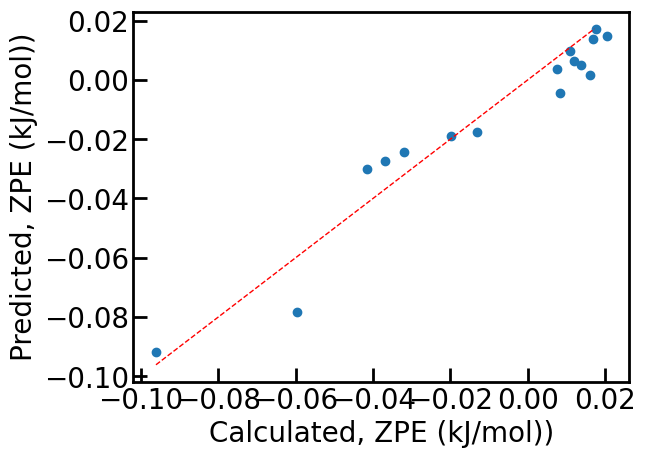

GB 0.8895393070570562
RMSE:  0.2906212529347883
RMSE unscaled:  0.010962484298333477
----------------------------------------


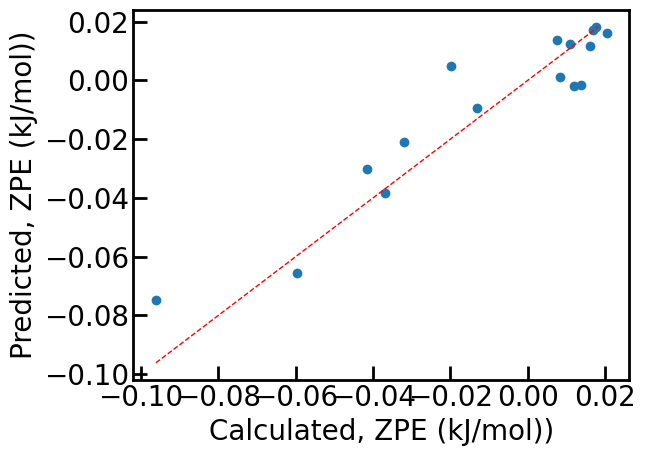

RR 0.9649567170361738
RMSE:  0.16369140707035615
RMSE unscaled:  0.006174581045466581
----------------------------------------


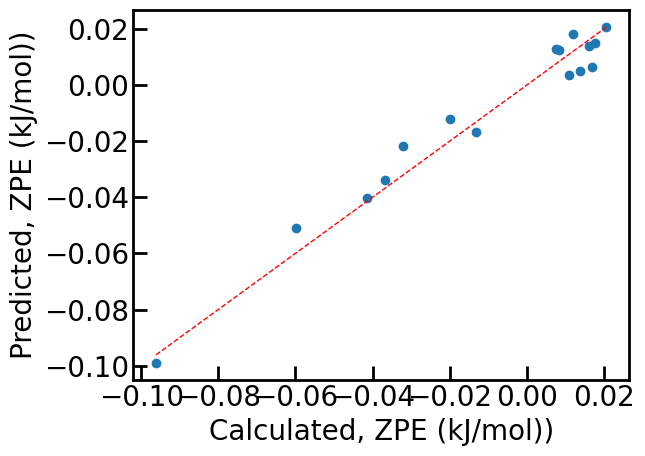

LASSO 0.9612710002391254
RMSE:  0.17208445055250798
RMSE unscaled:  0.00649117388394342
----------------------------------------


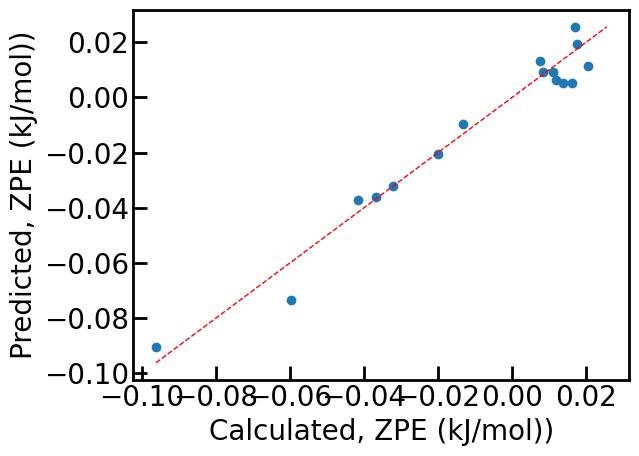

gpr1 0.9851553395127781
RMSE:  0.10653900188592819
RMSE unscaled:  0.004018743032522394
----------------------------------------


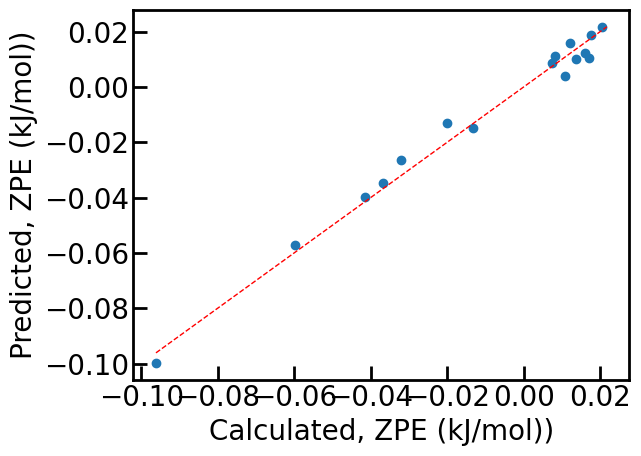

gpr2 0.979312846838276
RMSE:  0.12576907130786824
RMSE unscaled:  0.004744117835517905
----------------------------------------


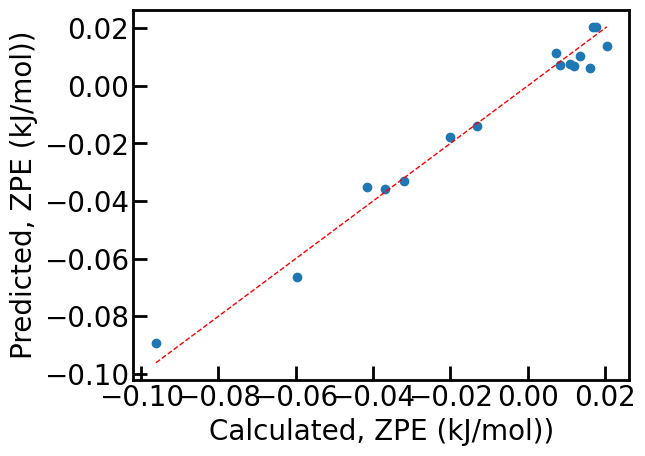

gpr3 0.9836761004374664
RMSE:  0.11172116251872388
RMSE unscaled:  0.004214218600791351
----------------------------------------


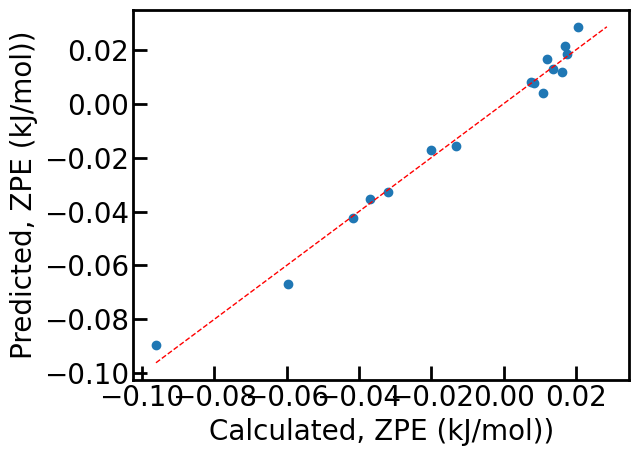

gpr4 0.9927776458594546
RMSE:  0.07431267231845011
RMSE unscaled:  0.0028031380886001742
----------------------------------------


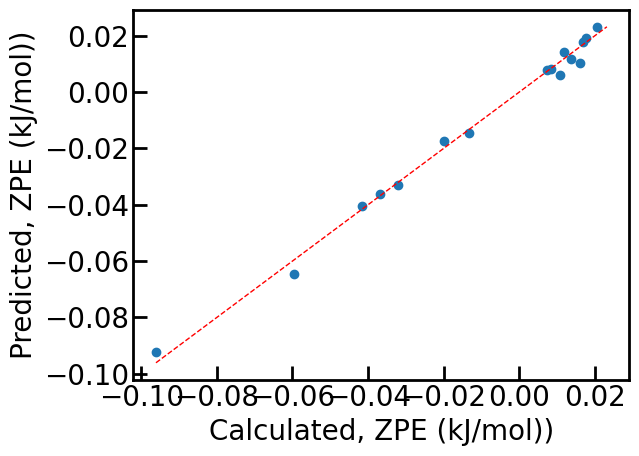

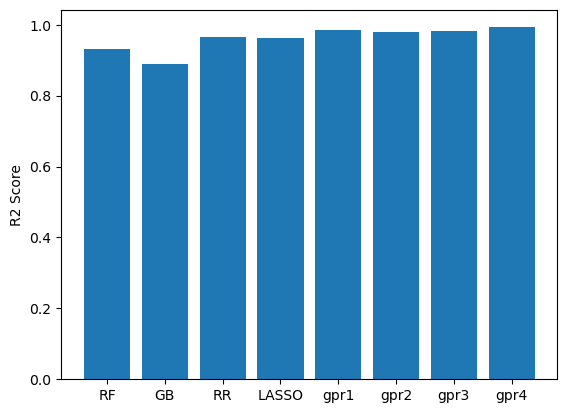

In [11]:
run_models()

In [12]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  304.626316
2        s_X  247.305616
17       X_Z  170.238631
36      X_Ra  128.535219
7   mean_X2X  124.838656
5   mean_A2X   77.660541
34    A_Rvdw   36.345858
1        s_B   36.264936
28      X_EA   35.663299
33    X_ChiA   35.347772
12     E_coh   34.613752
47   X_Kappa   32.665402
41     X_Rho   27.625739
0        s_A   27.355034
46   B_Kappa   24.049675
20     A_IEI   20.916890
22     X_IEI   17.961665
25    X_IEII   16.501438
27      B_EA   14.810073
43      X_MV   13.218705
9    std_A2X   12.381552
31    A_ChiA   10.636282
15       A_Z   10.101920
32    B_ChiA    9.580775
29    A_ChiP    9.324037
38      A_BP    8.499073
45   A_Kappa    7.987752
30    B_ChiP    6.612120
10   std_B2X    6.500297
16       B_Z    6.375766


In [13]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 'A_Rvdw',
       's_B', 'X_EA', 'X_ChiA', 'E_coh', 'X_Kappa', 'X_Rho', 's_A',
       'B_Kappa', 'A_IEI', 'X_IEI', 'X_IEII', 'B_EA', 'X_MV', 'std_A2X',
       'A_ChiA', 'A_Z', 'B_ChiA', 'A_ChiP', 'A_BP', 'A_Kappa', 'B_ChiP',
       'std_B2X', 'B_Z', 'B_MP', 'A_CvM', 'A_EA', 'B_IEI', 'B_Hf',
       'B_Rho', 'density', 'A_B', 'OF', 'A_G'], dtype=object)

In [14]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9178440361247077
RMSE:  0.250635761025118
RMSE unscaled:  0.009454197059205584
----------------------------------------


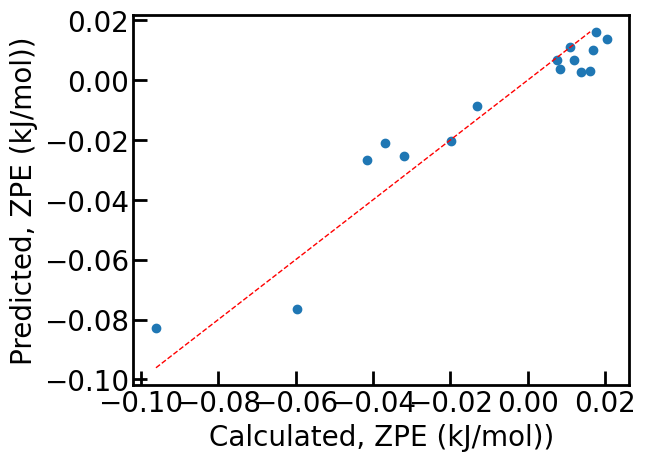

GB 0.9635486208899989
RMSE:  0.16694771189794846
RMSE unscaled:  0.00629741167186636
----------------------------------------


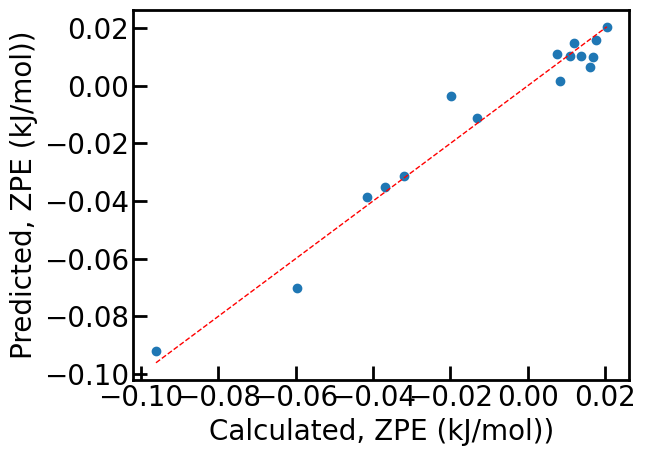

RR 0.9727943106833821
RMSE:  0.14422925367310638
RMSE unscaled:  0.005440451834768484
----------------------------------------


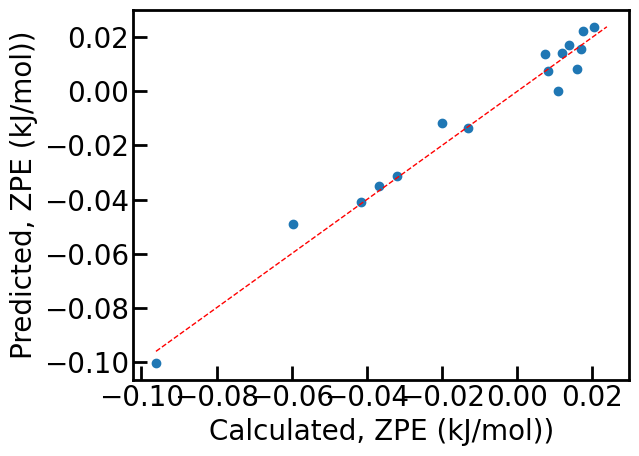

LASSO 0.9622646261339297
RMSE:  0.16986261970460906
RMSE unscaled:  0.006407364508208913
----------------------------------------


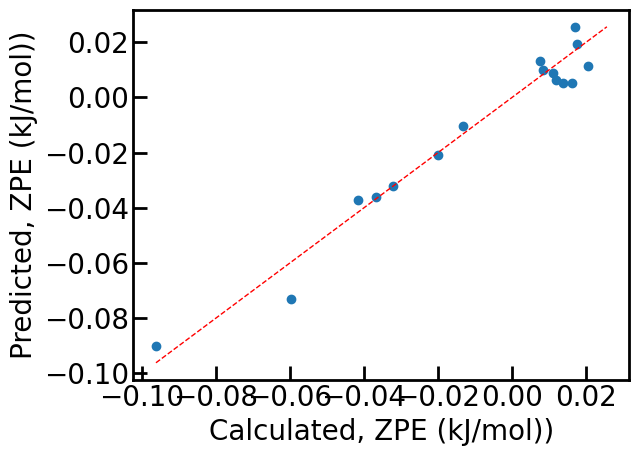

gpr1 0.9793603339825381
RMSE:  0.1256246375781726
RMSE unscaled:  0.004738669670671221
----------------------------------------


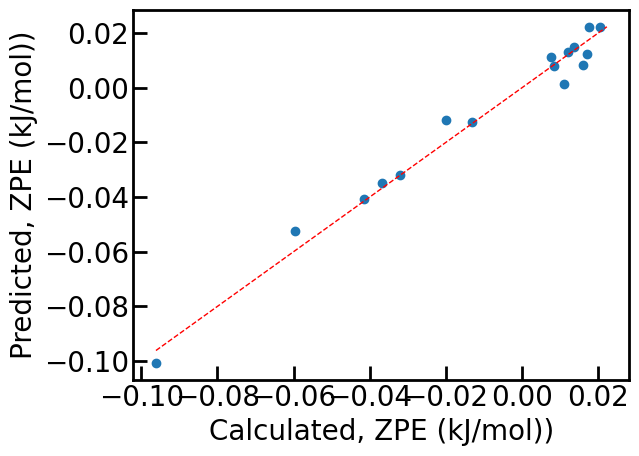

gpr2 0.9775667042478052
RMSE:  0.1309694579570726
RMSE unscaled:  0.004940280904844283
----------------------------------------


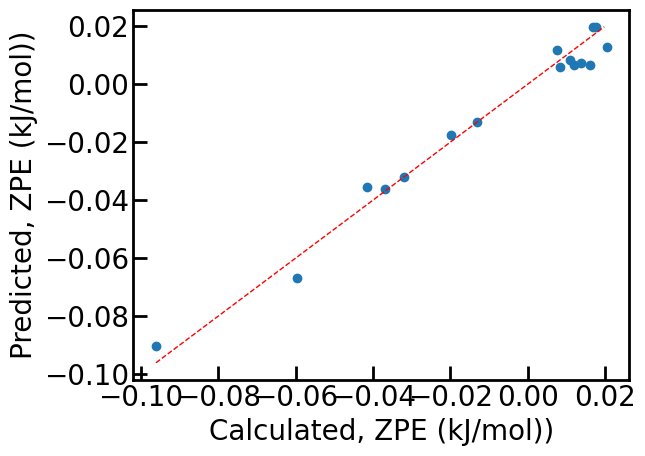

gpr3 0.9700944831826204
RMSE:  0.15121648724706865
RMSE unscaled:  0.0057040163111095775
----------------------------------------


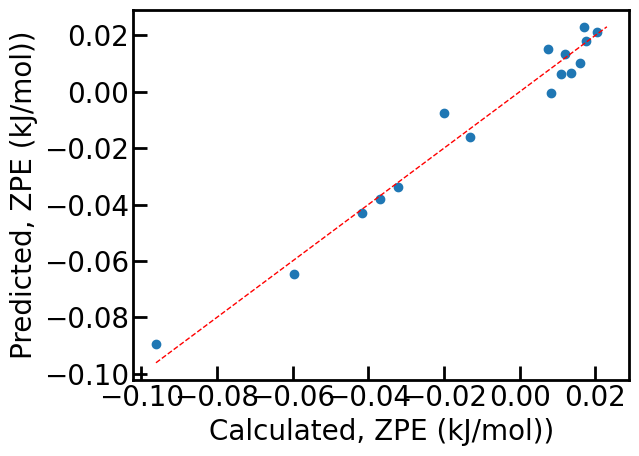

gpr4 0.9880566078807244
RMSE:  0.09556246301208342
RMSE unscaled:  0.003604698519812336
----------------------------------------


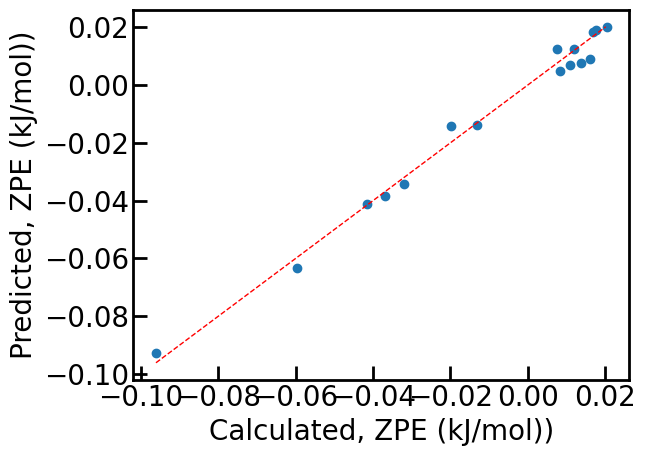

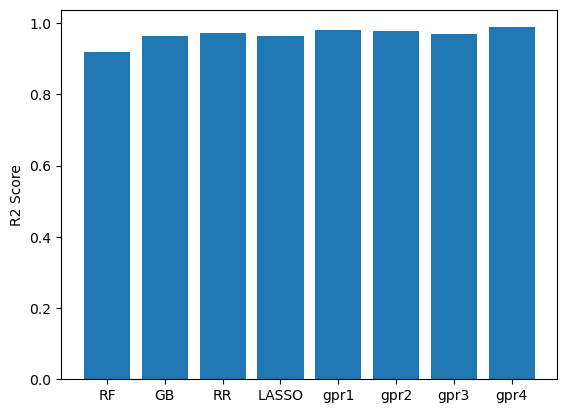

In [15]:
run_models()

In [16]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 'A_Rvdw',
       's_B', 'X_EA', 'X_ChiA', 'E_coh', 'X_Kappa', 'X_Rho', 's_A',
       'B_Kappa', 'A_IEI', 'X_IEI', 'X_IEII', 'B_EA', 'X_MV', 'std_A2X',
       'A_ChiA', 'A_Z', 'B_ChiA', 'A_ChiP', 'A_BP', 'A_Kappa', 'B_ChiP',
       'std_B2X', 'B_Z'], dtype=object)

In [17]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9117368992157774
RMSE:  0.25978440671289843
RMSE unscaled:  0.009799291864525324
----------------------------------------


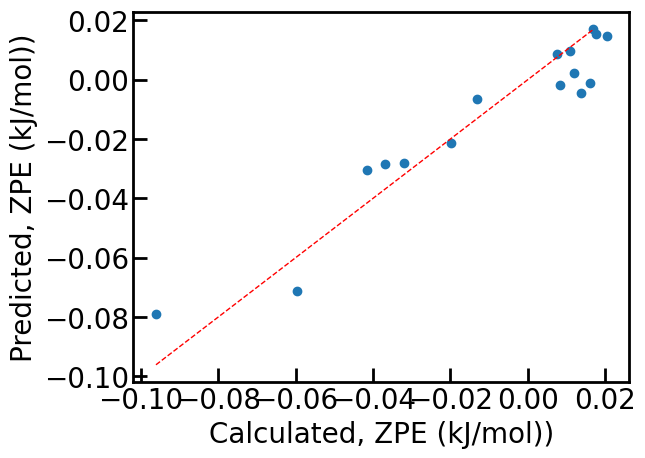

GB 0.9222352624338329
RMSE:  0.24384555563475505
RMSE unscaled:  0.00919806465587094
----------------------------------------


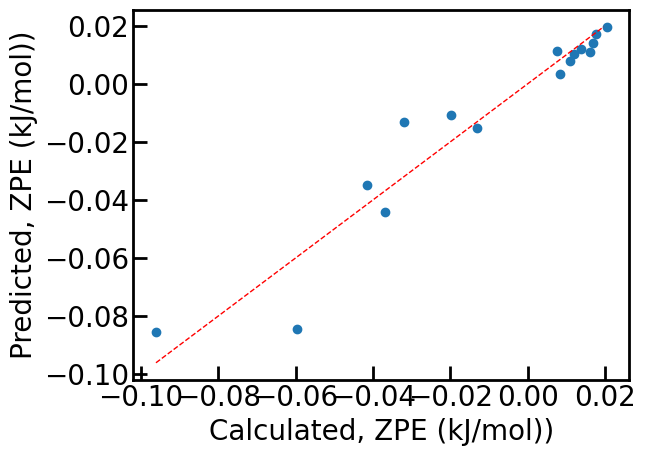

RR 0.9742079483192707
RMSE:  0.14043211423682603
RMSE unscaled:  0.005297220460502313
----------------------------------------


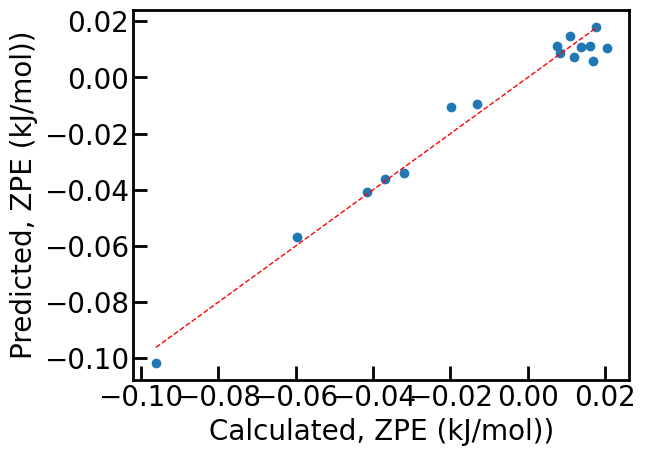

LASSO 0.9634479972914228
RMSE:  0.16717798167994688
RMSE unscaled:  0.006306097646632646
----------------------------------------


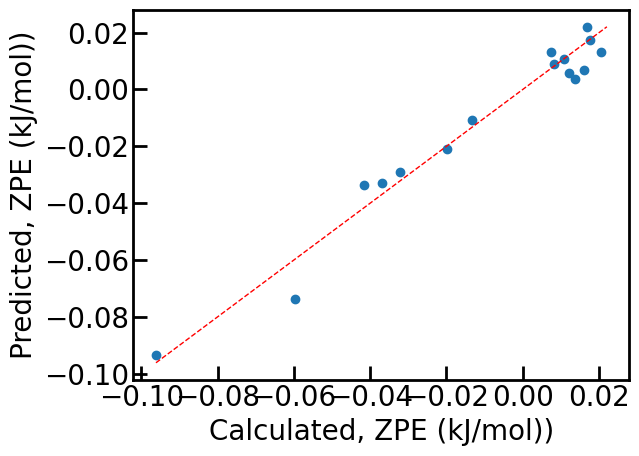

gpr1 0.9764383269932966
RMSE:  0.13422287944140943
RMSE unscaled:  0.00506300276904981
----------------------------------------


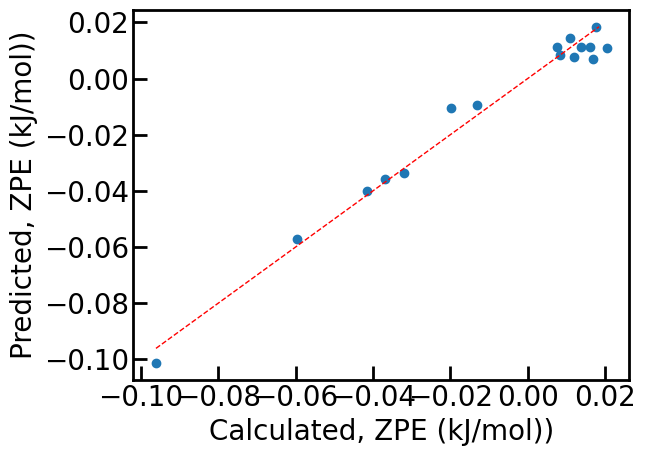

gpr2 0.9786145045581212
RMSE:  0.12787426402755186
RMSE unscaled:  0.004823527520465055
----------------------------------------


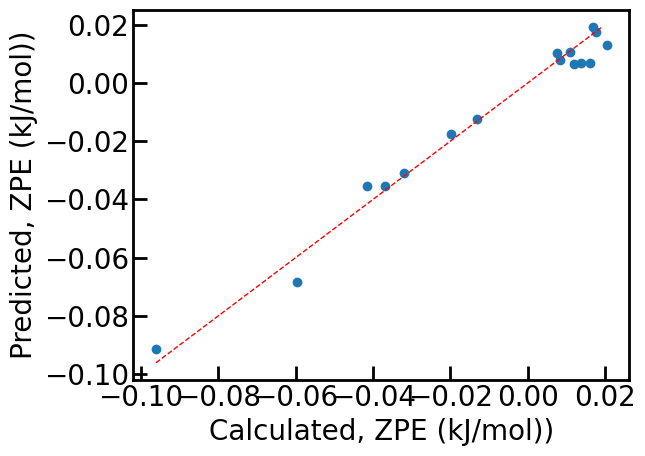

gpr3 0.9711971688818927
RMSE:  0.1484024524873241
RMSE unscaled:  0.005597868493091649
----------------------------------------


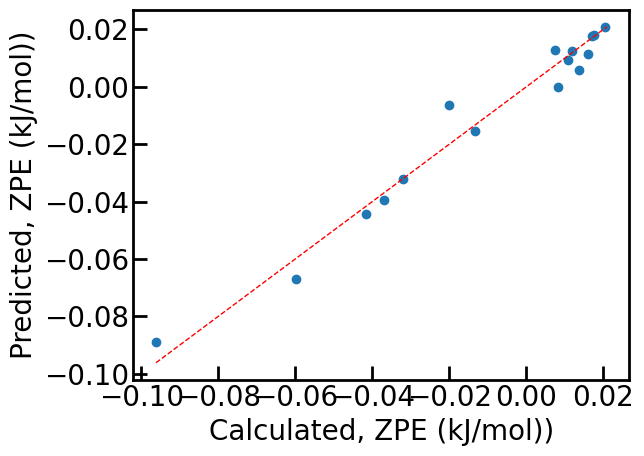

gpr4 0.9853456800542503
RMSE:  0.10585376844549323
RMSE unscaled:  0.00399289543619004
----------------------------------------


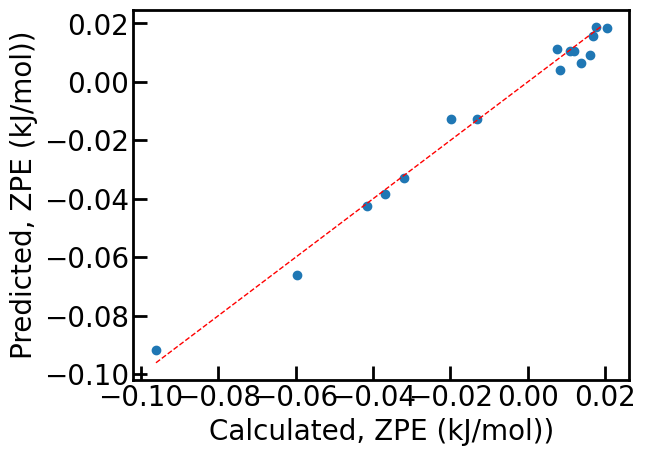

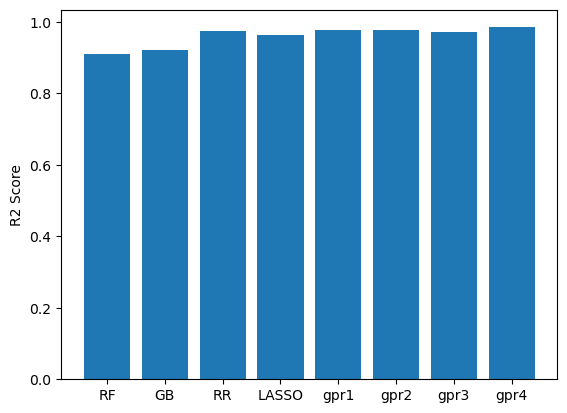

In [18]:
run_models()

In [19]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 'A_Rvdw',
       's_B', 'X_EA', 'X_ChiA', 'E_coh', 'X_Kappa', 'X_Rho', 's_A',
       'B_Kappa', 'A_IEI', 'X_IEI', 'X_IEII', 'B_EA', 'X_MV'],
      dtype=object)

In [20]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.9225689440509033
RMSE:  0.2433218333535998
RMSE unscaled:  0.0091783093997571
----------------------------------------


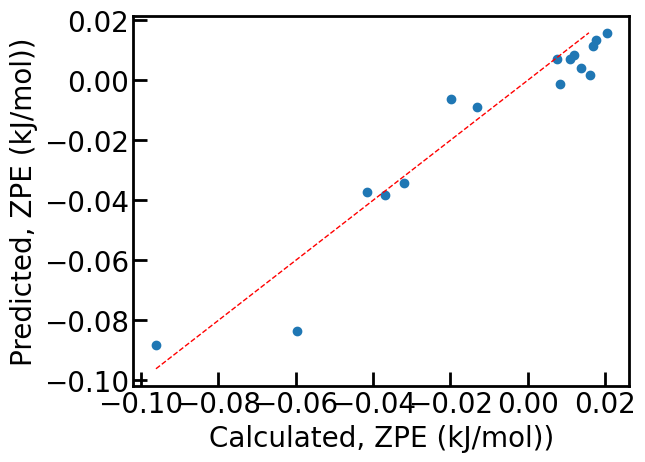

GB 0.8926749319359036
RMSE:  0.2864666539922831
RMSE unscaled:  0.010805769243212214
----------------------------------------


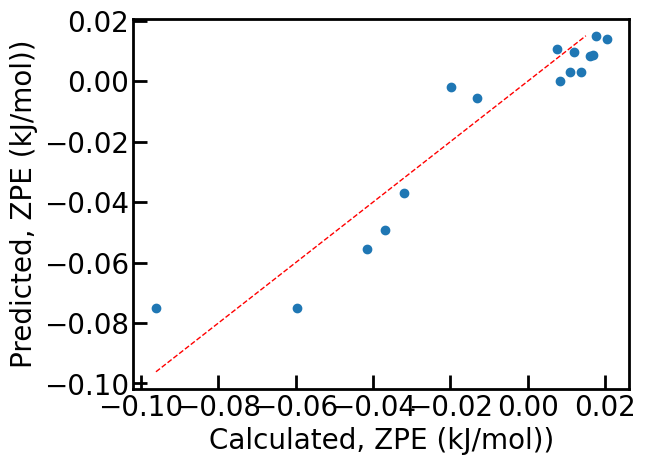

RR 0.9355512703475792
RMSE:  0.22198859875197996
RMSE unscaled:  0.008373601392371973
----------------------------------------


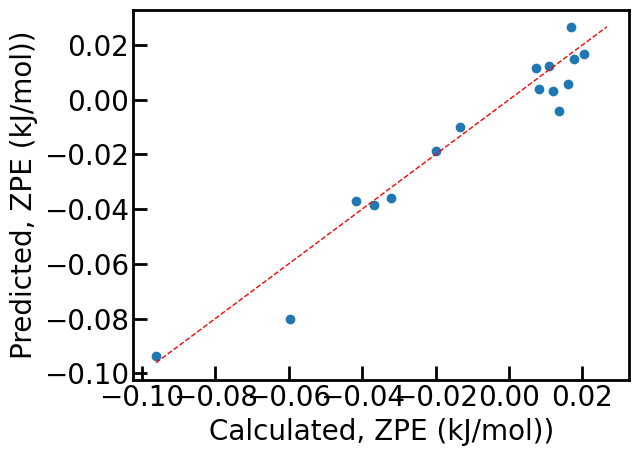

LASSO 0.9146836034593293
RMSE:  0.2554110845286209
RMSE unscaled:  0.009634326380093068
----------------------------------------


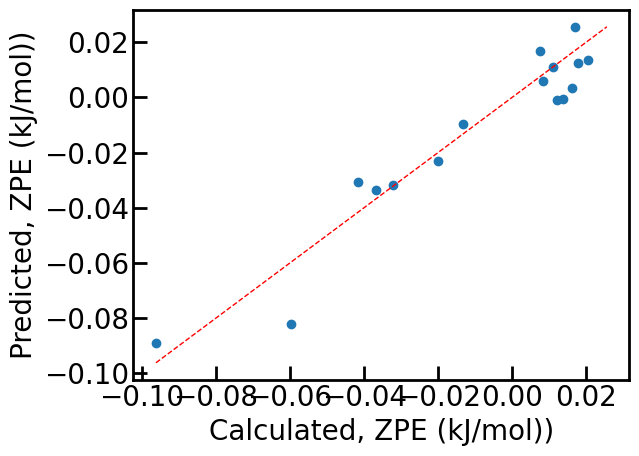

gpr1 0.938096745218274
RMSE:  0.21756059166037625
RMSE unscaled:  0.008206573146074009
----------------------------------------


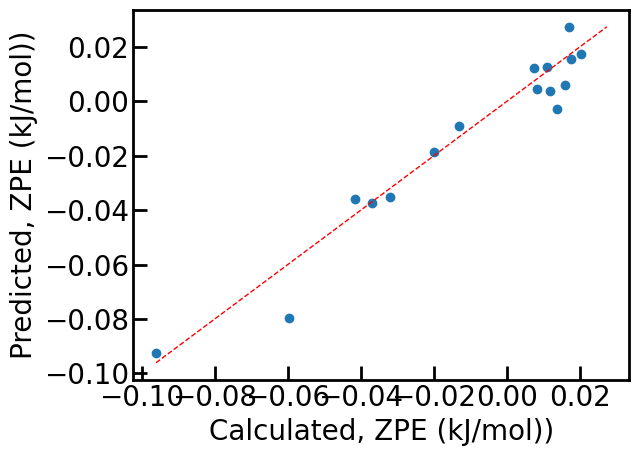

gpr2 0.9368887499157574
RMSE:  0.21967310083199046
RMSE unscaled:  0.008286258813897837
----------------------------------------


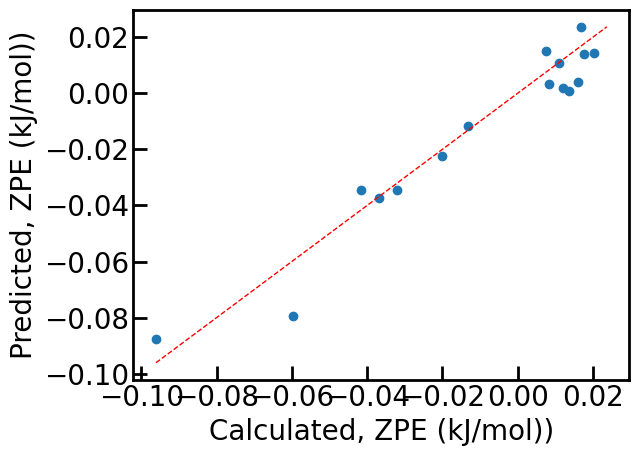

gpr3 0.9375971376512362
RMSE:  0.21843676921873625
RMSE unscaled:  0.008239623319208555
----------------------------------------


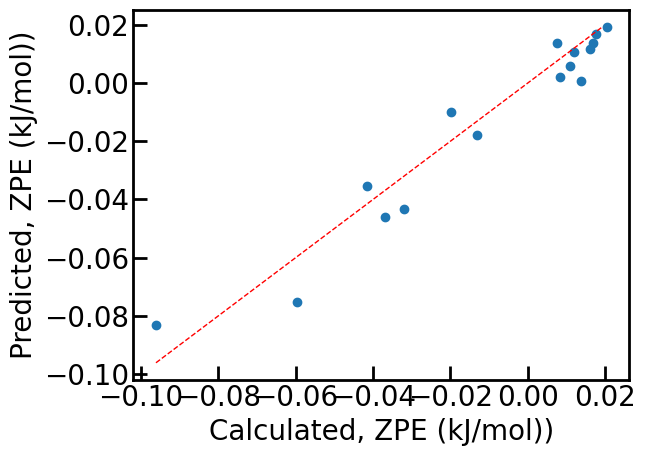

gpr4 0.9523274346437699
RMSE:  0.19092278047917613
RMSE unscaled:  0.007201771935333228
----------------------------------------


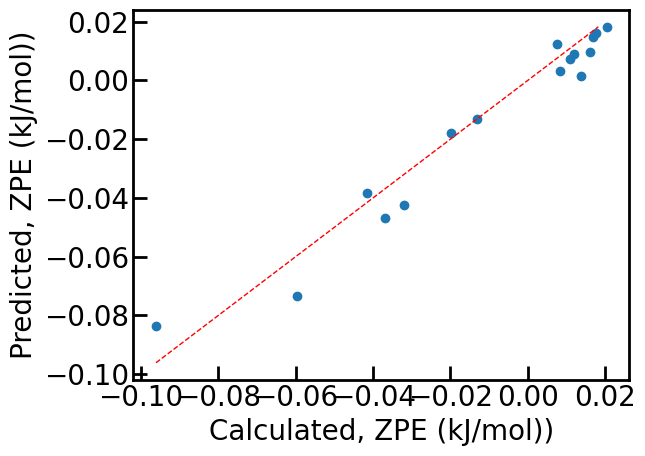

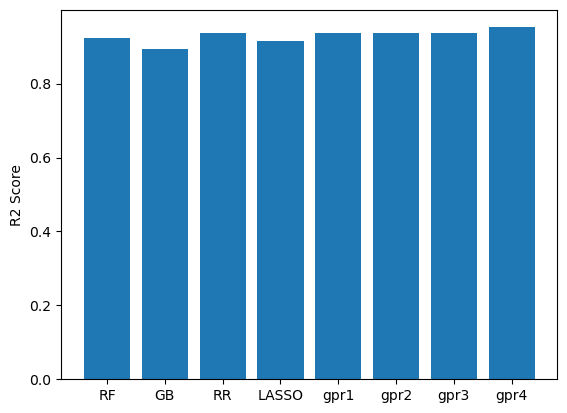

In [21]:
run_models()

In [22]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 'A_Rvdw',
       's_B', 'X_EA', 'X_ChiA'], dtype=object)

In [23]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.841652362360098
RMSE:  0.34795996895443954
RMSE unscaled:  0.013125350116660514
----------------------------------------


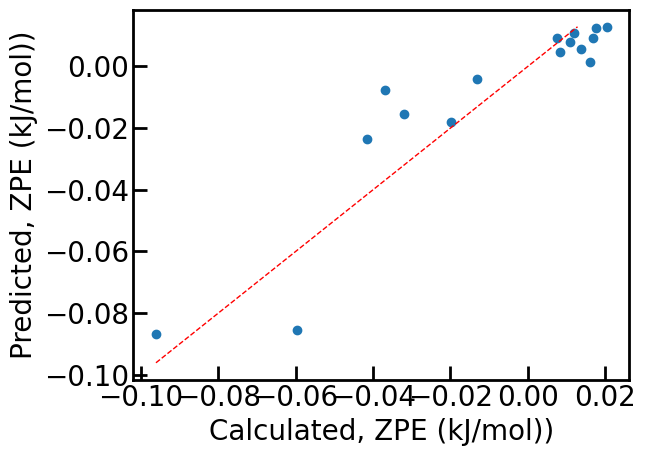

GB 0.9072956737055922
RMSE:  0.2662401137670923
RMSE unscaled:  0.010042806702141555
----------------------------------------


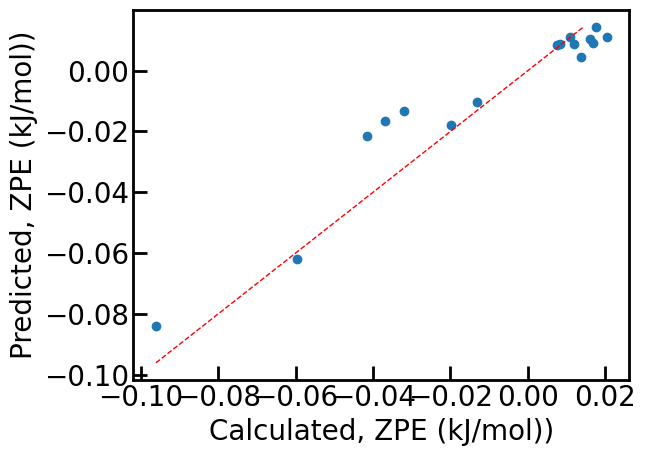

RR 0.7842318856333055
RMSE:  0.4061786784497318
RMSE unscaled:  0.01532141004781286
----------------------------------------


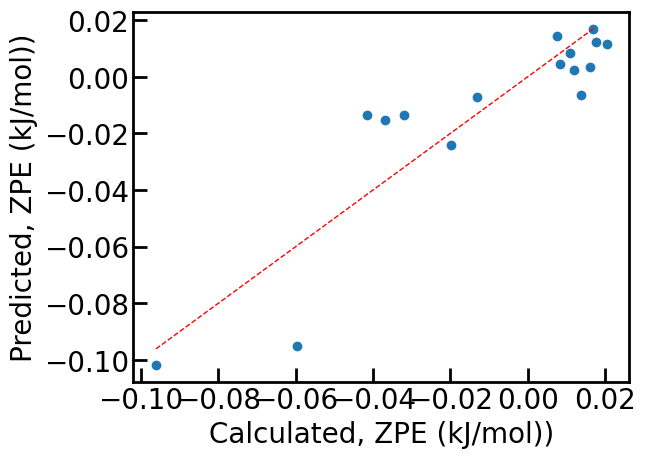

LASSO 0.8045291694536403
RMSE:  0.3866023309999613
RMSE unscaled:  0.014582973338970422
----------------------------------------


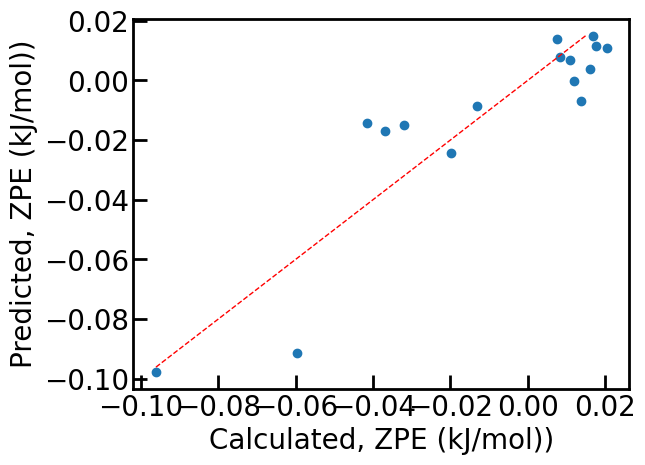

gpr1 0.7851690767972074
RMSE:  0.4052955977230519
RMSE unscaled:  0.015288099481215853
----------------------------------------


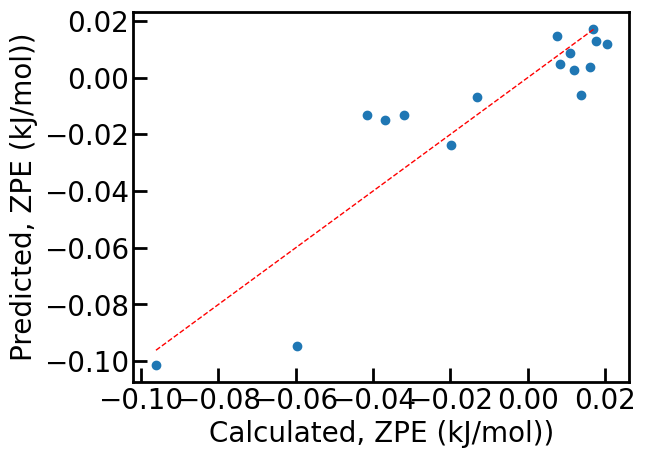

gpr2 0.8090762742968775
RMSE:  0.3820792384106853
RMSE unscaled:  0.014412358385696607
----------------------------------------


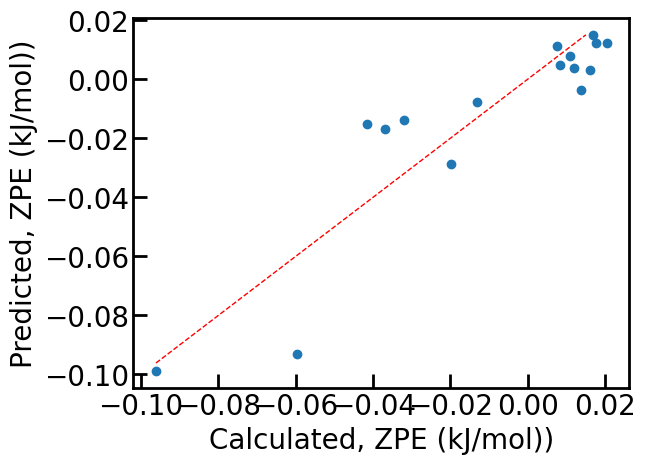

gpr3 0.8765090973727022
RMSE:  0.3072847246051077
RMSE unscaled:  0.01159104482065216
----------------------------------------


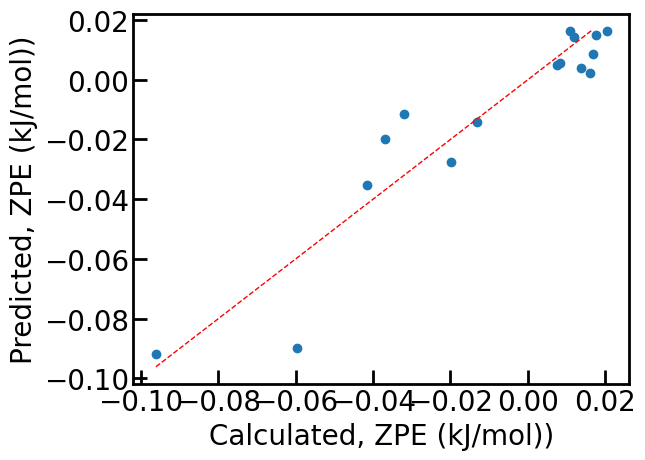

gpr4 0.875353433836164
RMSE:  0.30871920595294006
RMSE unscaled:  0.011645154694218061
----------------------------------------


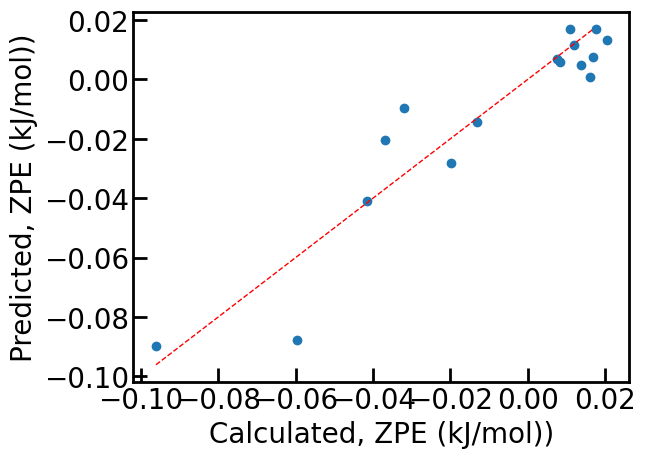

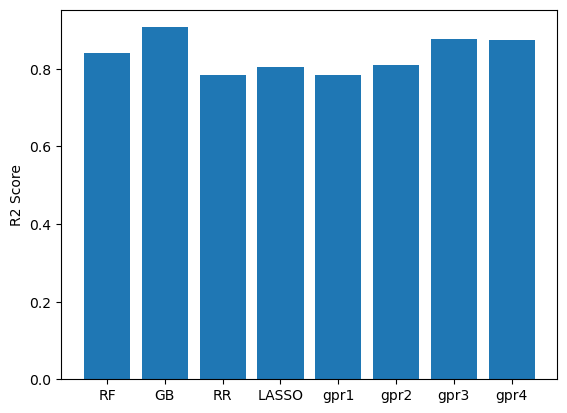

In [24]:
run_models()

# Min-Max scaling

In [25]:
data_std=d.copy()
scaler=MinMaxScaler()
scaler.fit(np.array(data[target]).reshape(-1, 1))
data_zpe_mm= scaler.transform(np.array(data[target]).reshape(-1, 1))
data_std[columns]= MinMaxScaler().fit_transform(d[columns])
Y = data_std[target] 
X = data_std.drop([target], axis=1)

In [26]:
correlated_features = ["A_Rc","A_Ra","A_M","A_MP","A_MV","A_MendeleevNo","A_Hf","A_Hv","B_Rc",
                       "B_Rvdw","B_M","B_BP","B_MendeleevNo","B_Hv","X_Rc","X_Rvdw","X_M","X_BP","X_MP",
                       "X_MendeleevNo","X_Hf","X_Hv","X_G","X_B","X_CvM","X_ChiP"]
data_std.drop(labels=correlated_features, axis=1, inplace=True)
print(data_std.shape)
Y = data_std[target] 
X = data_std.drop([target], axis=1)

(80, 53)


### Test-train splitting 

In [27]:
# split into train and test
df_train, df_test = train_test_split(data_std, 
                                     train_size = 0.8, 
                                     test_size = 0.2, 
                                     random_state = 50)
df_train.reset_index(inplace = True)
df_test.reset_index(inplace = True)
df_train=df_train.drop('index',axis=1)
df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train.pop(target)
X = df_train

Y_test = df_test.pop(target)
X_test = df_test

RF 0.9084333685336385
RMSE:  0.06436678550068477
RMSE unscaled:  0.009980992323020573
----------------------------------------


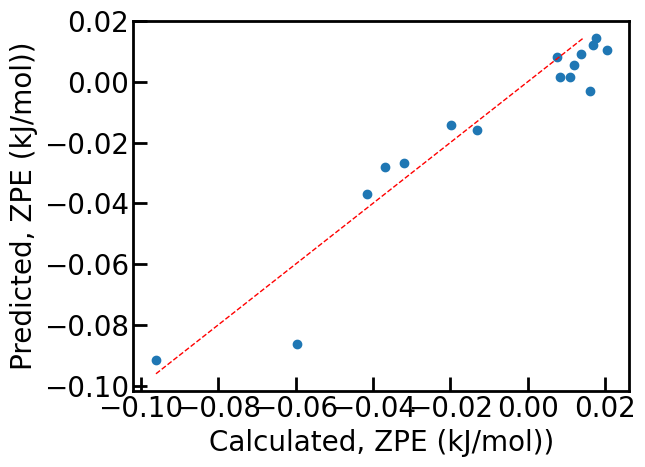

GB 0.9099805743474154
RMSE:  0.06382066436492644
RMSE unscaled:  0.009896308416234748
----------------------------------------


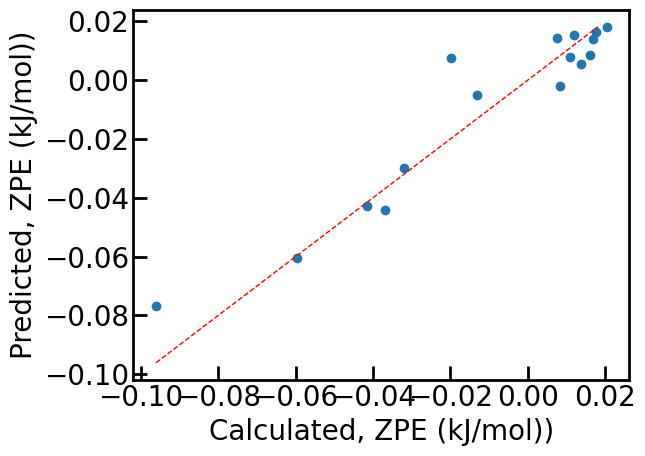

RR 0.9860258017043314
RMSE:  0.025145290238329433
RMSE unscaled:  0.0038991375268572367
----------------------------------------


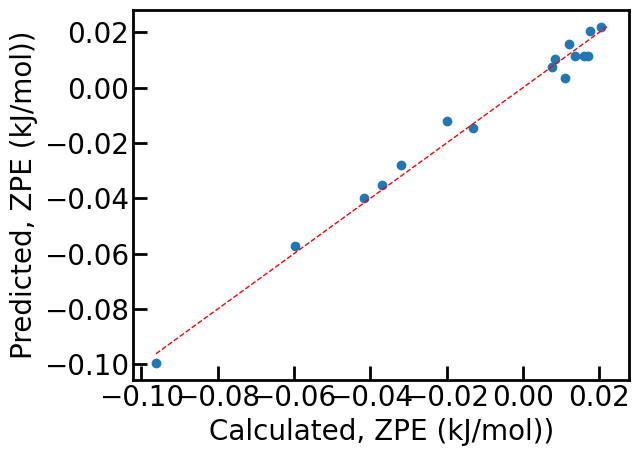

LASSO 0.6623258527957447
RMSE:  0.12360672728804822
RMSE unscaled:  0.019166994072161363
----------------------------------------


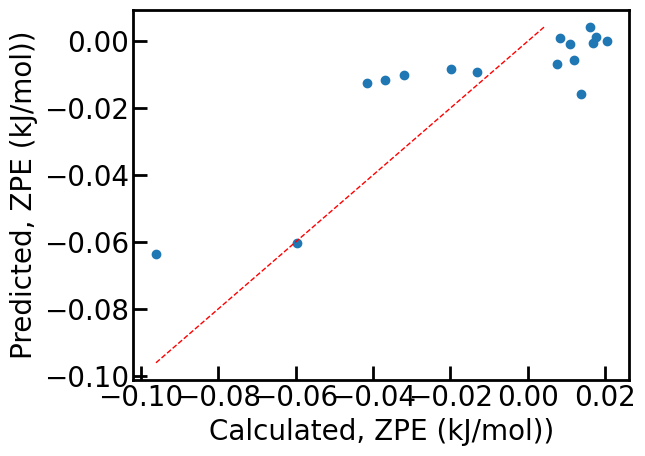

gpr1 0.9345413399351914
RMSE:  0.0544222831452441
RMSE unscaled:  0.00843895475047693
----------------------------------------


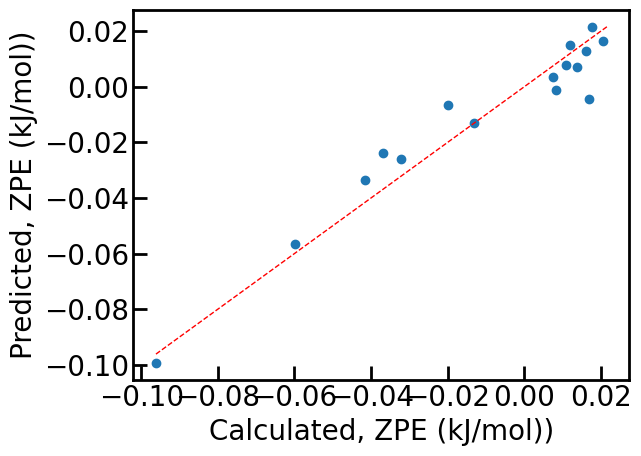

gpr2 -0.015673429938449557
RMSE:  0.2143730799943775
RMSE unscaled:  0.0332416175367868
----------------------------------------


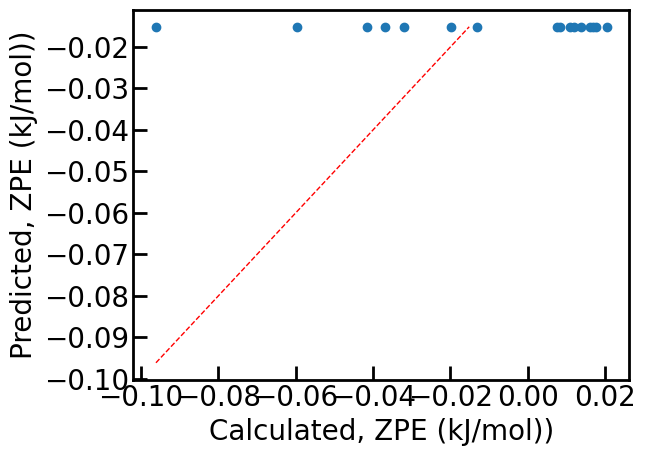

gpr3 0.9907514340908613
RMSE:  0.020456456180072746
RMSE unscaled:  0.003172066625687571
----------------------------------------


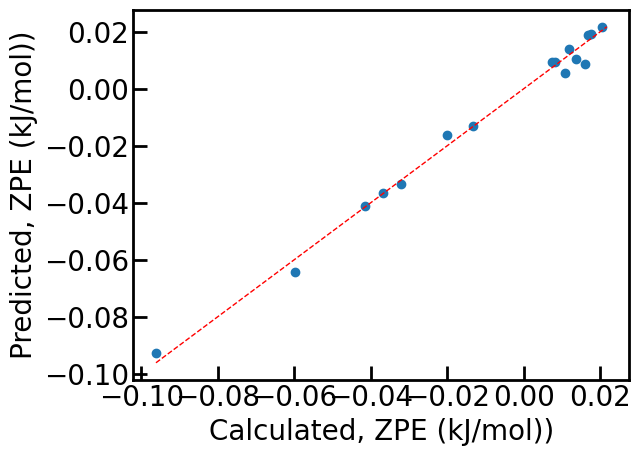

gpr4 0.9719321580336844
RMSE:  0.03563671905618382
RMSE unscaled:  0.00552598388362314
----------------------------------------


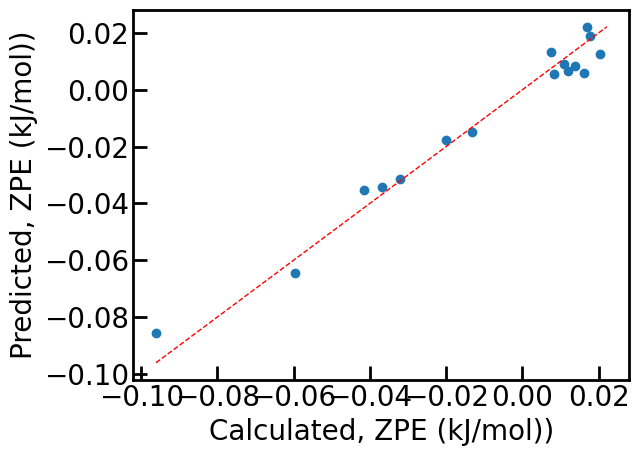

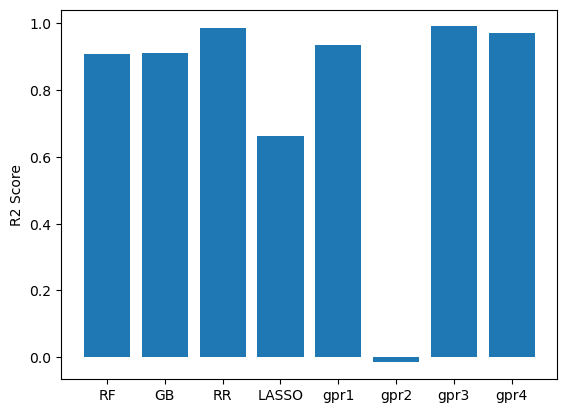

In [28]:
run_models()

## Feature selection


In [29]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
4   mean_A2B  304.626316
2        s_X  247.305616
17       X_Z  170.238631
36      X_Ra  128.535219
7   mean_X2X  124.838656
5   mean_A2X   77.660541
34    A_Rvdw   36.345858
1        s_B   36.264936
28      X_EA   35.663299
33    X_ChiA   35.347772
12     E_coh   34.613752
47   X_Kappa   32.665402
41     X_Rho   27.625739
0        s_A   27.355034
46   B_Kappa   24.049675
20     A_IEI   20.916890
22     X_IEI   17.961665
25    X_IEII   16.501438
27      B_EA   14.810073
43      X_MV   13.218705
9    std_A2X   12.381552
31    A_ChiA   10.636282
15       A_Z   10.101920
32    B_ChiA    9.580775
29    A_ChiP    9.324037
38      A_BP    8.499073
45   A_Kappa    7.987752
30    B_ChiP    6.612120
10   std_B2X    6.500297
16       B_Z    6.375766


In [30]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 'A_Rvdw',
       's_B', 'X_EA', 'X_ChiA', 'E_coh', 'X_Kappa', 'X_Rho', 's_A',
       'B_Kappa', 'A_IEI', 'X_IEI', 'X_IEII', 'B_EA', 'X_MV', 'std_A2X',
       'A_ChiA', 'A_Z', 'B_ChiA', 'A_ChiP', 'A_BP', 'A_Kappa', 'B_ChiP',
       'std_B2X', 'B_Z', 'B_MP', 'A_CvM', 'A_EA', 'B_IEI', 'B_Hf',
       'B_Rho', 'density', 'A_B', 'OF', 'A_G'], dtype=object)

In [31]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9090913035182073
RMSE:  0.06413512082718457
RMSE unscaled:  0.009945069396161101
----------------------------------------


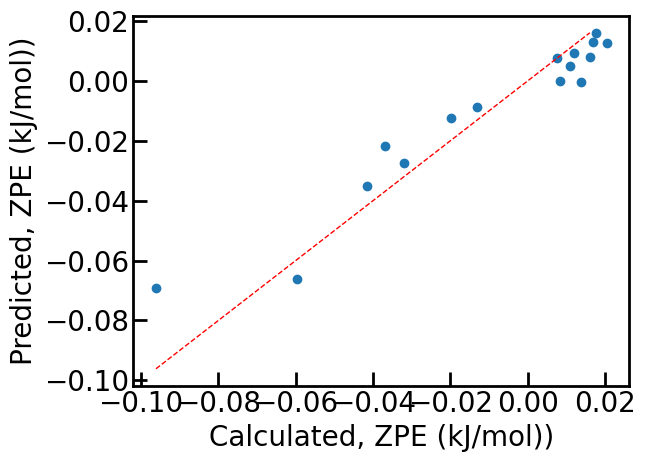

GB 0.9010958138733999
RMSE:  0.06689605984831826
RMSE unscaled:  0.010373192549428869
----------------------------------------


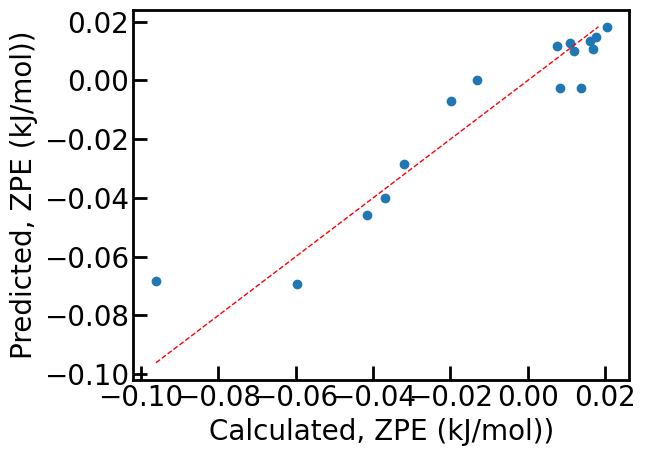

RR 0.9810005678377124
RMSE:  0.029319969396022116
RMSE unscaled:  0.0045464813440121475
----------------------------------------


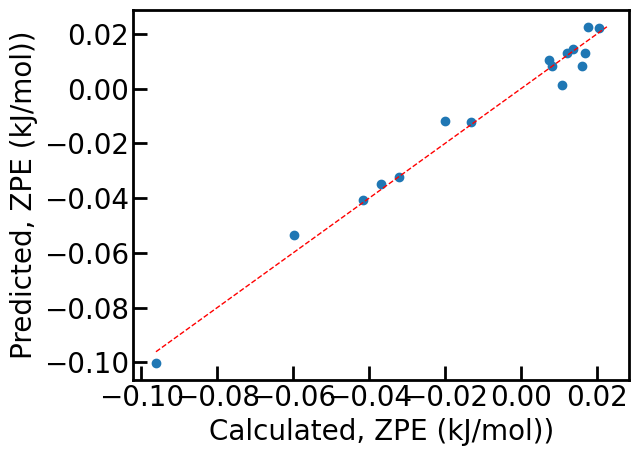

LASSO 0.6623778856039753
RMSE:  0.1235972035312346
RMSE unscaled:  0.019165517277213415
----------------------------------------


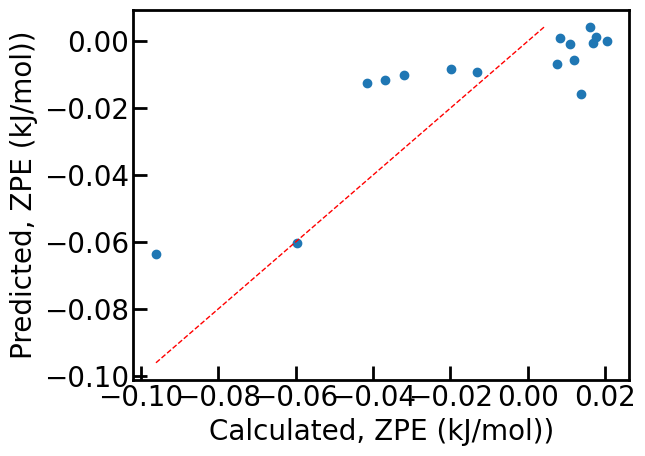

gpr1 0.9408912050654433
RMSE:  0.05171532456611306
RMSE unscaled:  0.00801920203815989
----------------------------------------


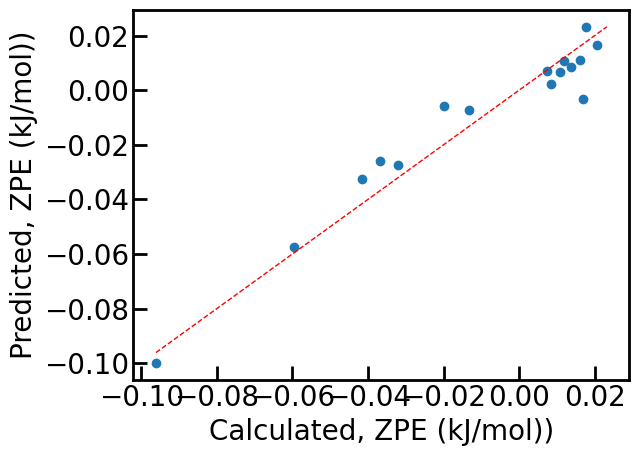

gpr2 -0.015673426483984176
RMSE:  0.21437307962981916
RMSE unscaled:  0.03324161748025681
----------------------------------------


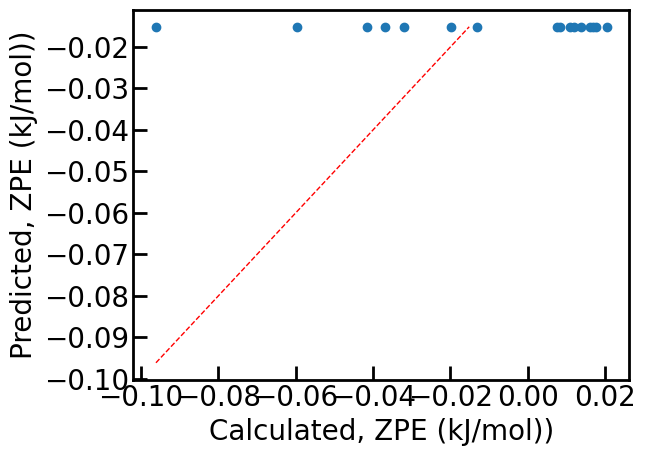

gpr3 0.9877877289376944
RMSE:  0.023506686732201375
RMSE unscaled:  0.0036450485757325186
----------------------------------------


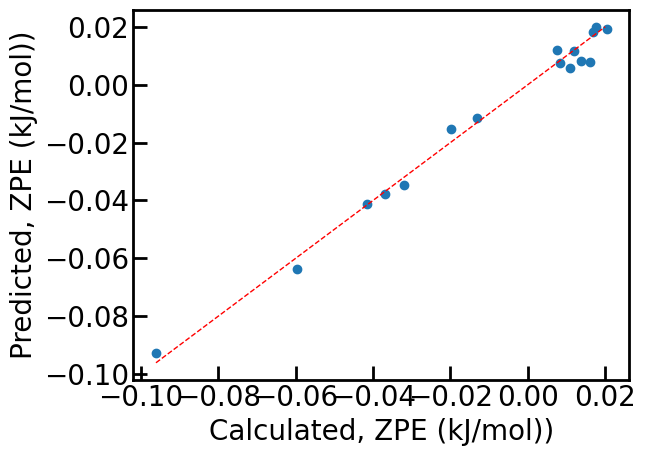

gpr4 0.9734566208395078
RMSE:  0.0346554312372179
RMSE unscaled:  0.005373821147647017
----------------------------------------


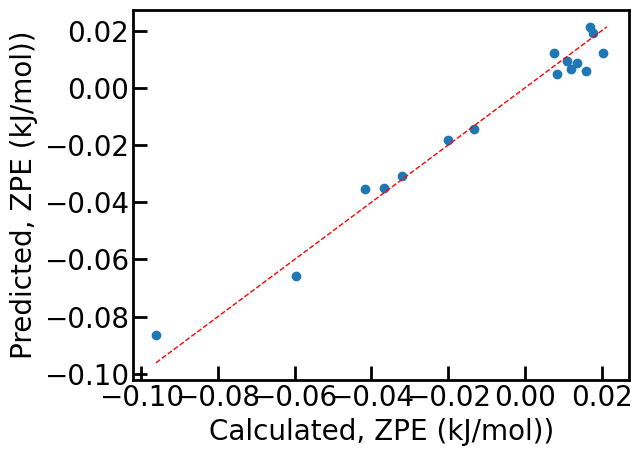

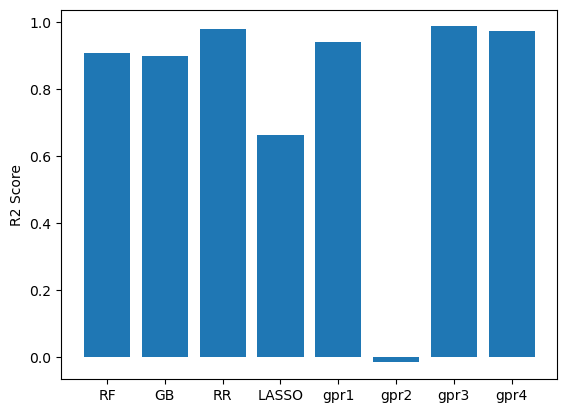

In [32]:
run_models()

In [33]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 'A_Rvdw',
       's_B', 'X_EA', 'X_ChiA', 'E_coh', 'X_Kappa', 'X_Rho', 's_A',
       'B_Kappa', 'A_IEI', 'X_IEI', 'X_IEII', 'B_EA', 'X_MV', 'std_A2X',
       'A_ChiA', 'A_Z', 'B_ChiA', 'A_ChiP', 'A_BP', 'A_Kappa', 'B_ChiP',
       'std_B2X', 'B_Z'], dtype=object)

In [34]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9260667708328624
RMSE:  0.057837969723031256
RMSE unscaled:  0.008968605893462395
----------------------------------------


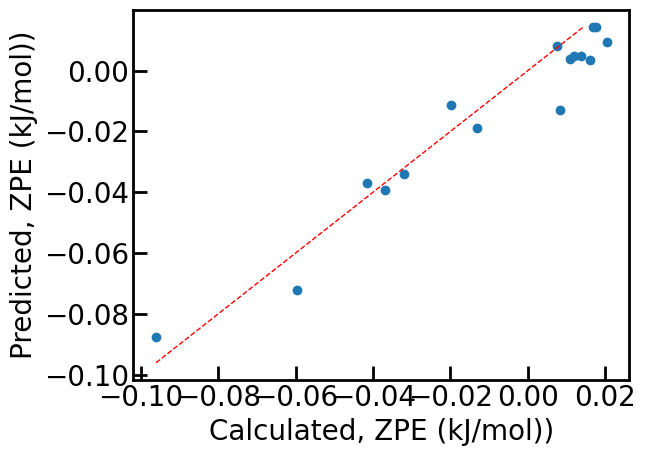

GB 0.9422510520120014
RMSE:  0.051116986216382734
RMSE unscaled:  0.007926421104192576
----------------------------------------


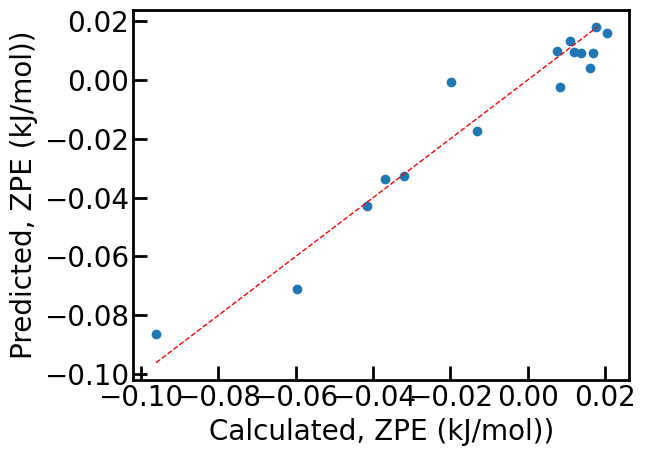

RR 0.977989406985937
RMSE:  0.03155797107417078
RMSE unscaled:  0.004893515569735153
----------------------------------------


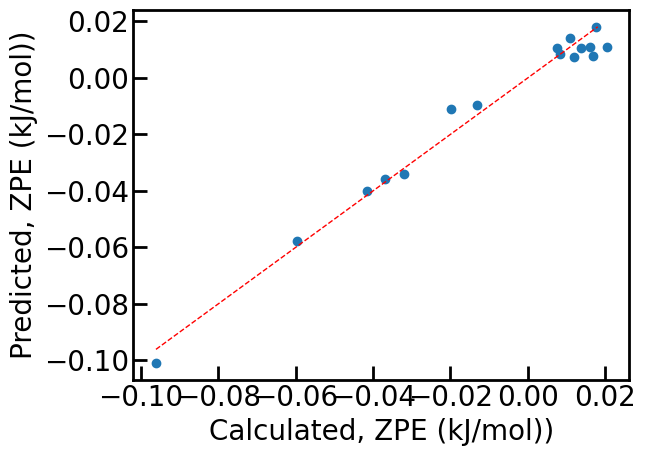

LASSO 0.6623778856039753
RMSE:  0.1235972035312346
RMSE unscaled:  0.019165517277213415
----------------------------------------


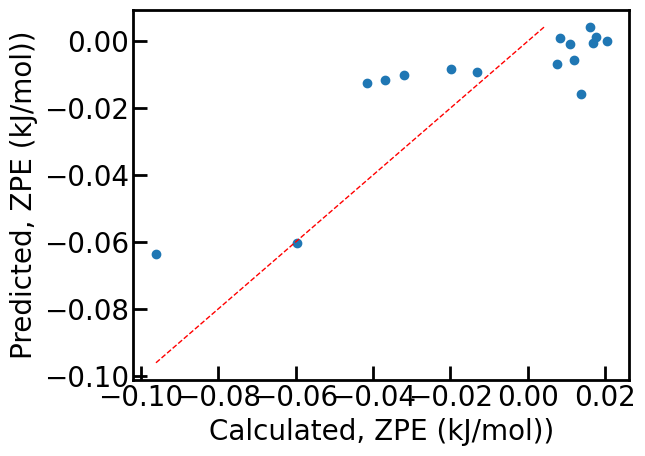

gpr1 0.9544462070083539
RMSE:  0.04539996038895676
RMSE unscaled:  0.007039914337539736
----------------------------------------


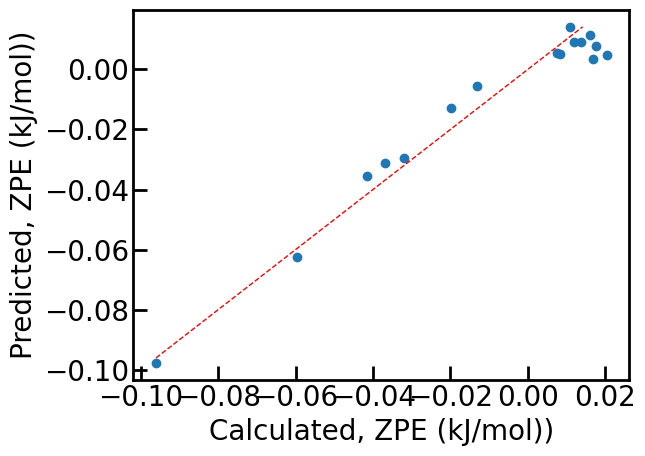

gpr2 -0.015673428630072372
RMSE:  0.21437307985630116
RMSE unscaled:  0.03324161751537609
----------------------------------------


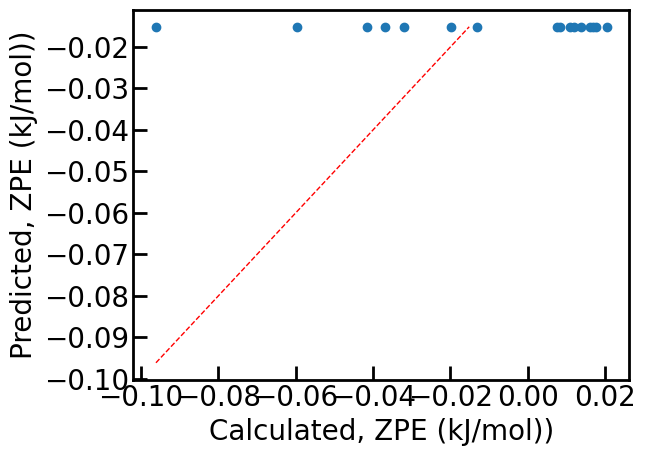

gpr3 0.9817701719611691
RMSE:  0.02872000346573505
RMSE unscaled:  0.004453448030359946
----------------------------------------


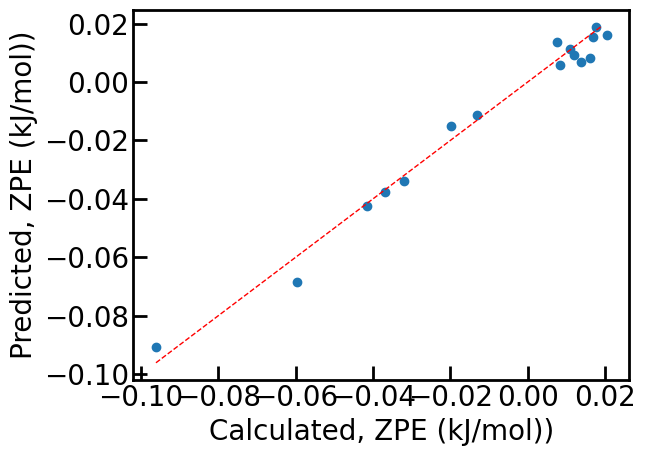

gpr4 0.9751660203982103
RMSE:  0.03352095337786287
RMSE unscaled:  0.005197904101040131
----------------------------------------


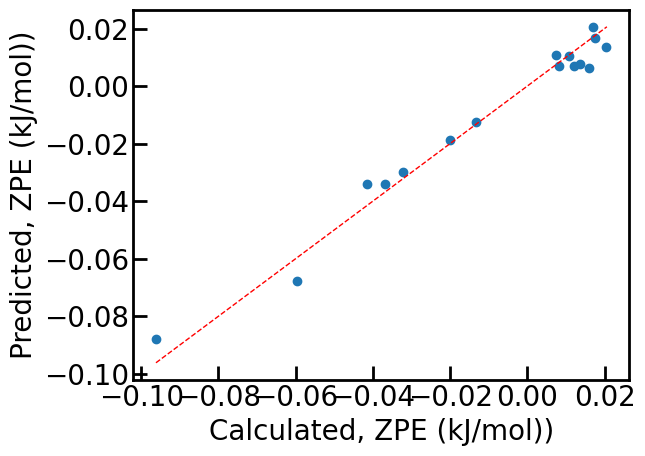

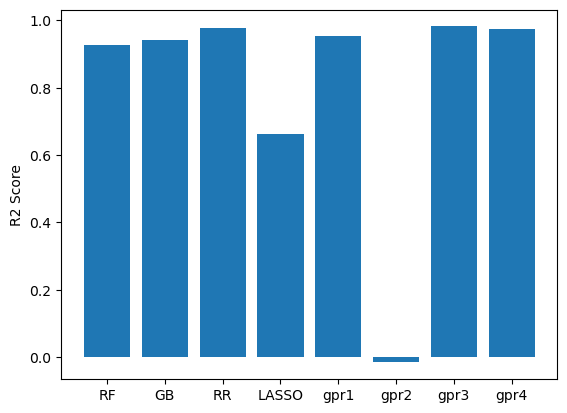

In [35]:
run_models()

In [36]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 'A_Rvdw',
       's_B', 'X_EA', 'X_ChiA', 'E_coh', 'X_Kappa', 'X_Rho', 's_A',
       'B_Kappa', 'A_IEI', 'X_IEI', 'X_IEII', 'B_EA', 'X_MV'],
      dtype=object)

In [37]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.917119564270578
RMSE:  0.06123774849764467
RMSE unscaled:  0.009495790303642766
----------------------------------------


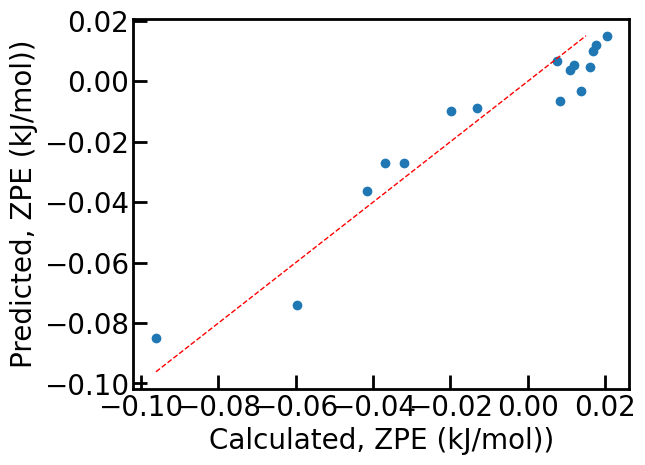

GB 0.8861044865678014
RMSE:  0.07178711668496186
RMSE unscaled:  0.011131620989784614
----------------------------------------


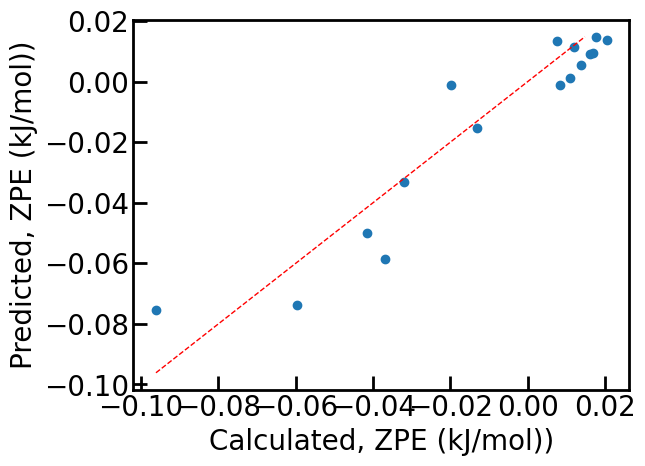

RR 0.9351828570092424
RMSE:  0.05415494812086553
RMSE unscaled:  0.008397500624637932
----------------------------------------


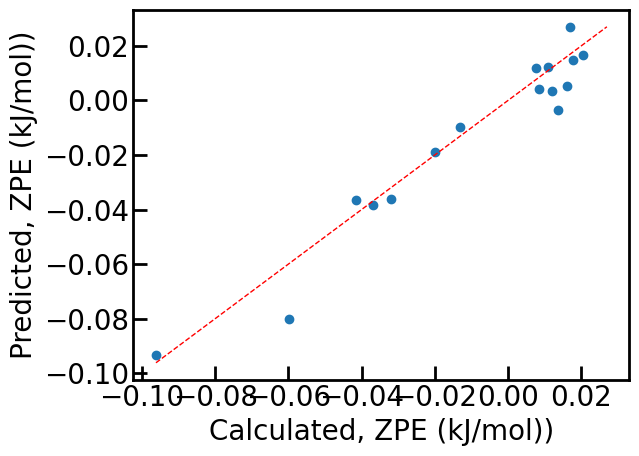

LASSO 0.6623778856039753
RMSE:  0.1235972035312346
RMSE unscaled:  0.019165517277213415
----------------------------------------


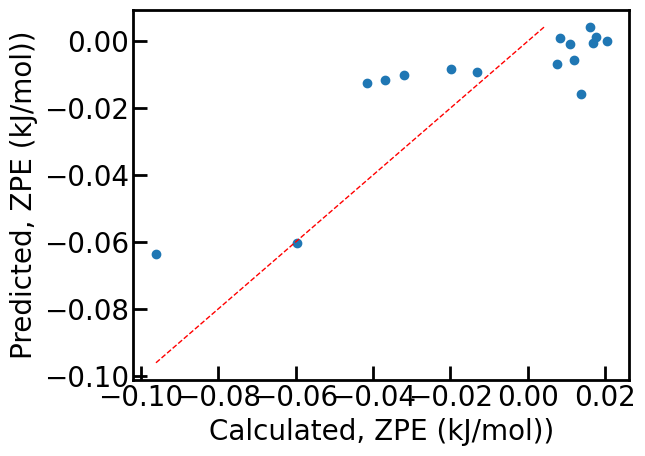

gpr1 0.9283692571458229
RMSE:  0.05693022883877231
RMSE unscaled:  0.0088278476634746
----------------------------------------


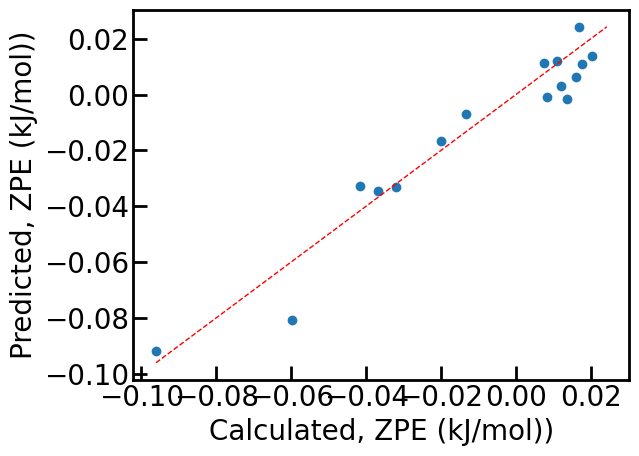

gpr2 -0.01567339111518562
RMSE:  0.21437307589726196
RMSE unscaled:  0.03324161690147033
----------------------------------------


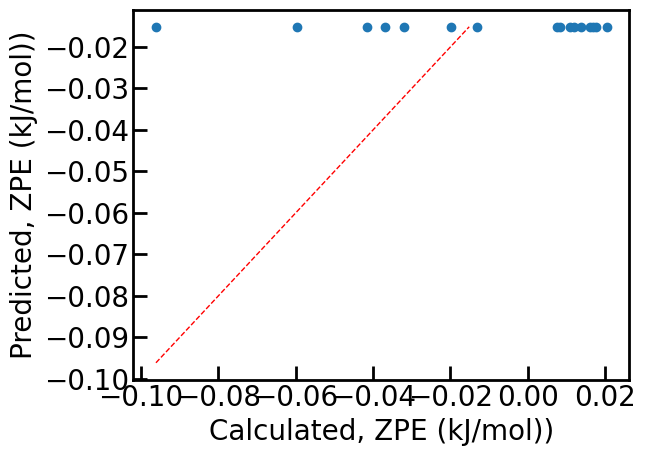

gpr3 0.9570894003666677
RMSE:  0.04406314520966395
RMSE unscaled:  0.006832621990438187
----------------------------------------


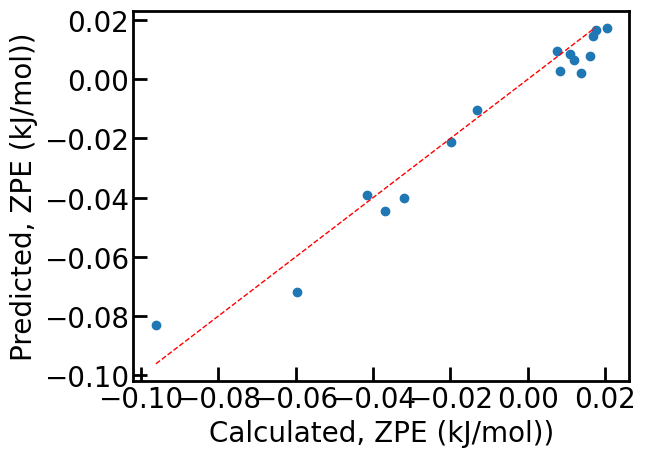

gpr4 0.9375626203265431
RMSE:  0.05315150133880371
RMSE unscaled:  0.008241901823945732
----------------------------------------


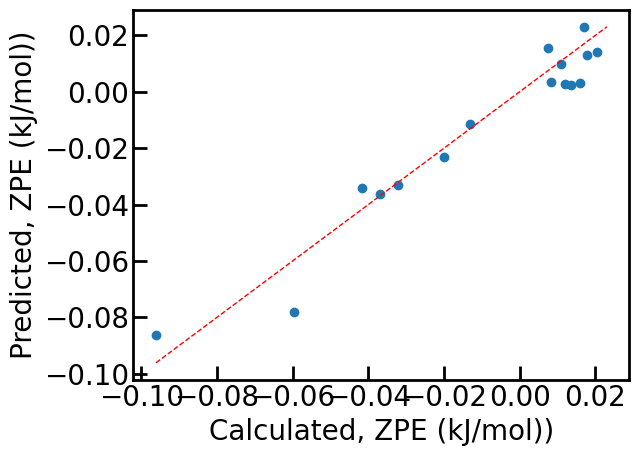

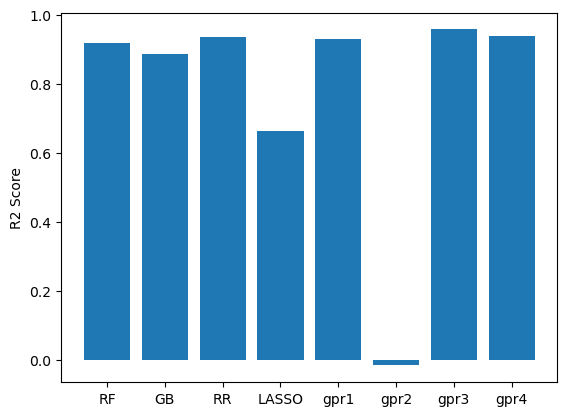

In [38]:
run_models()

In [39]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 's_X', 'X_Z', 'X_Ra', 'mean_X2X', 'mean_A2X', 'A_Rvdw',
       's_B', 'X_EA', 'X_ChiA'], dtype=object)

In [40]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.7995225844404998
RMSE:  0.09524143482481226
RMSE unscaled:  0.01476854906494907
----------------------------------------


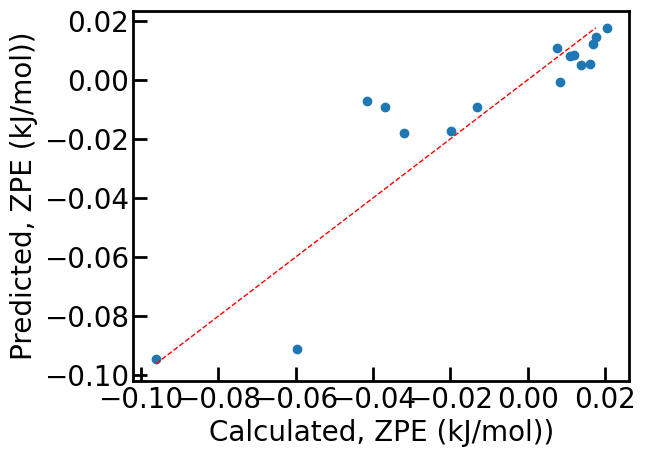

GB 0.9012875140775605
RMSE:  0.06683119804186123
RMSE unscaled:  0.010363134797014032
----------------------------------------


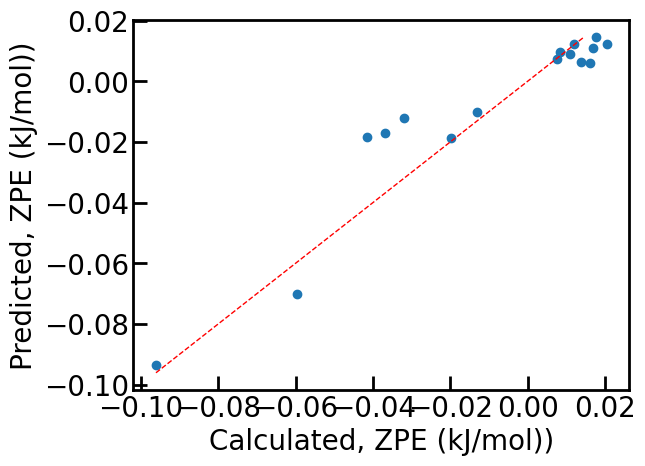

RR 0.7852877972902841
RMSE:  0.09856473659805043
RMSE unscaled:  0.015283874620322933
----------------------------------------


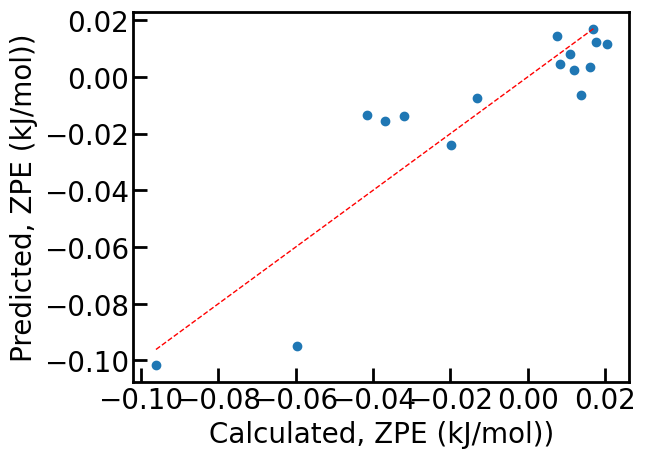

LASSO 0.6623778856039753
RMSE:  0.1235972035312346
RMSE unscaled:  0.019165517277213415
----------------------------------------


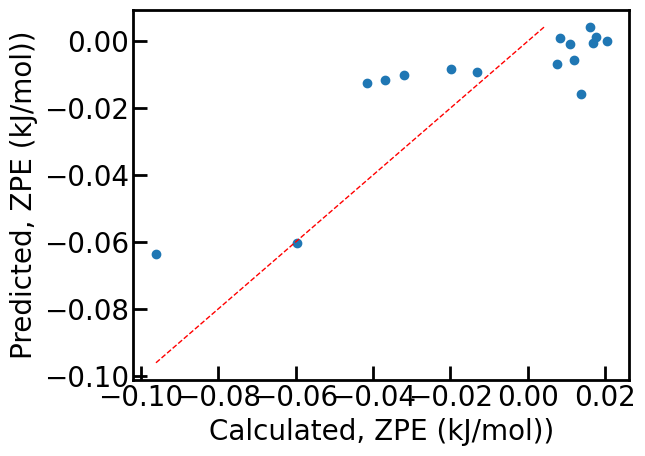

gpr1 0.7658064187727021
RMSE:  0.10293917797791066
RMSE unscaled:  0.01596219443216788
----------------------------------------


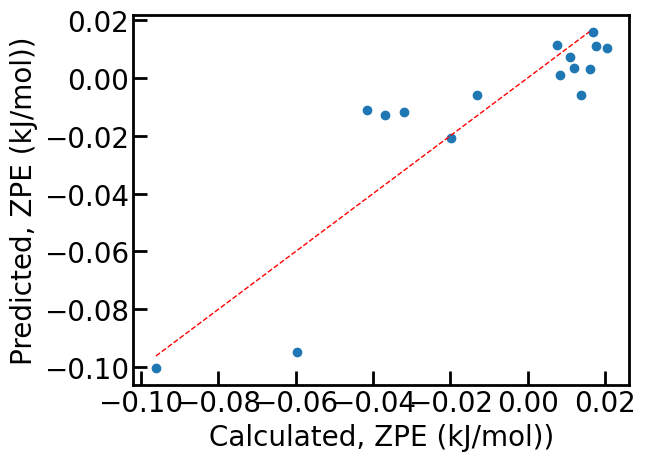

gpr2 -0.01567342646311687
RMSE:  0.21437307962761698
RMSE unscaled:  0.033241617479915324
----------------------------------------


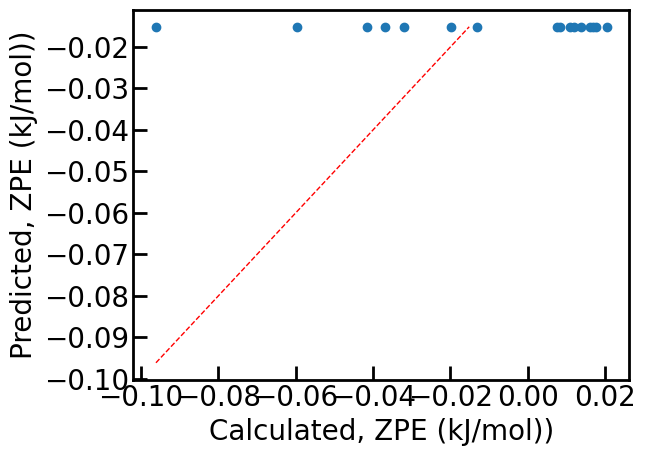

gpr3 0.8841950457784846
RMSE:  0.07238636553811868
RMSE unscaled:  0.011224543110353665
----------------------------------------


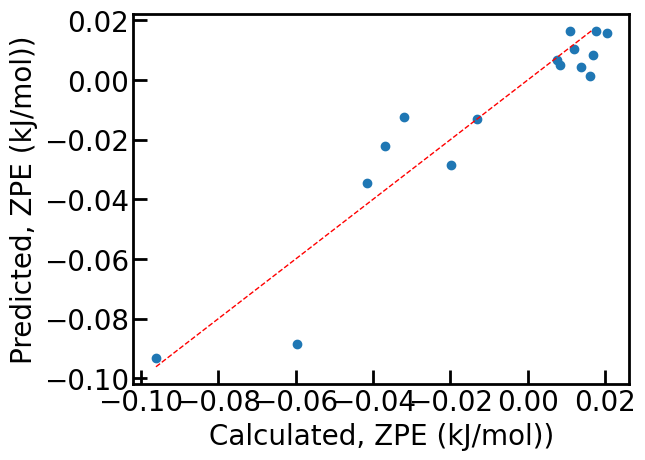

gpr4 0.8096434007160438
RMSE:  0.09280623849387261
RMSE unscaled:  0.014390936982955353
----------------------------------------


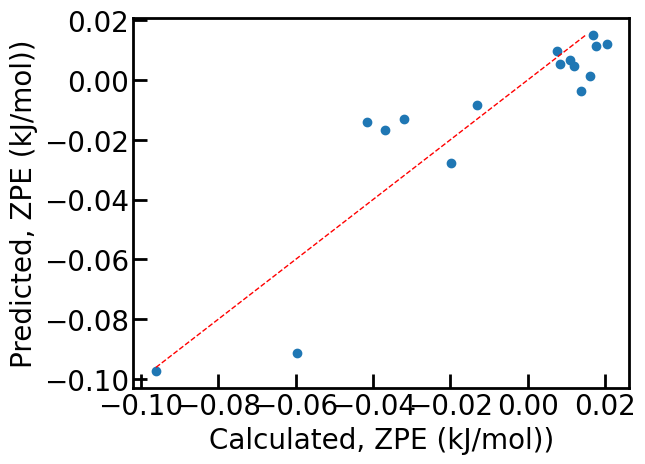

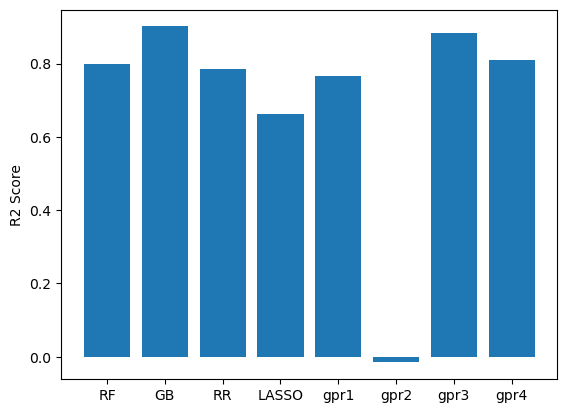

In [41]:
run_models()